# Imports

In [17]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [18]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [19]:
from utils import label_map_util

from utils import visualization_utils as vis_util

In [20]:
%cd D:\ssd_Tomato

D:\ssd_Tomato


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [21]:
# What model to download.
MODEL_NAME = 'D:\ssd_Tomato'
##MODEL_FILE = MODEL_NAME + '.tar.gz'
##DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'label_map.pbtxt')

## Download Model

In [22]:
##opener = urllib.request.URLopener()
##opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
##tar_file = tarfile.open(MODEL_FILE)
##for file in tar_file.getmembers():
  ##file_name = os.path.basename(file.name)
  ##if 'frozen_inference_graph.pb' in file_name:
    ##tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [23]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [24]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [25]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [26]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [27]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

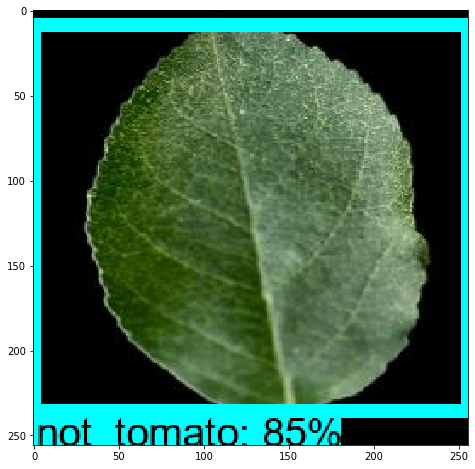

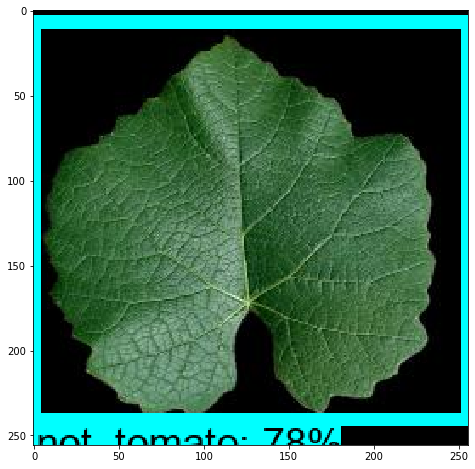

In [36]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [1]:
import tensorflow as tf

In [19]:
%cd D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master\output
    

D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master\output


In [20]:
gf = tf.GraphDef()
gf.ParseFromString(open('frozen_inference_graph.pb','rb').read())

22730475

In [21]:
import tensorflow as tf
gf = tf.GraphDef()   
m_file = open('frozen_inference_graph.pb','rb')
gf.ParseFromString(m_file.read())

#We get the names of the nodes
for n in gf.node:
    print( n.name )

#To get the tensor
tensor = n.op

Const
image_tensor
ToFloat
Preprocessor/map/Shape
Preprocessor/map/strided_slice/stack
Preprocessor/map/strided_slice/stack_1
Preprocessor/map/strided_slice/stack_2
Preprocessor/map/strided_slice
Preprocessor/map/TensorArray
Preprocessor/map/TensorArrayUnstack/Shape
Preprocessor/map/TensorArrayUnstack/strided_slice/stack
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2
Preprocessor/map/TensorArrayUnstack/strided_slice
Preprocessor/map/TensorArrayUnstack/range/start
Preprocessor/map/TensorArrayUnstack/range/delta
Preprocessor/map/TensorArrayUnstack/range
Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3
Preprocessor/map/Const
Preprocessor/map/TensorArray_1
Preprocessor/map/TensorArray_2
Preprocessor/map/while/iteration_counter
Preprocessor/map/while/Enter
Preprocessor/map/while/Enter_1
Preprocessor/map/while/Enter_2
Preprocessor/map/while/Enter_3
Preprocessor/map/while/Merge
Preprocessor/map/whi

MultipleGridAnchorGenerator/Meshgrid_10/Rank
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ExpandDims/input
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ExpandDims/dim
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ExpandDims
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Slice/begin
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Slice
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Reshape/shape
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Reshape
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ones/Const
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/ones
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Slice_1/size
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/Slice_1
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/concat/axis
MultipleGridAnchorGenerator/Meshgrid_10/ExpandedShape/concat
MultipleGridAnchorGenerator/Meshgrid_10/Shape_1
MultipleGridAnchorGenerator/Meshgrid_10/Rank_1
MultipleGridAnchorG

Postprocessor/zeros_like_1
Postprocessor/truediv
Postprocessor/truediv_1
Postprocessor/stack_1
Postprocessor/BatchMultiClassNonMaxSuppression/Shape
Postprocessor/BatchMultiClassNonMaxSuppression/strided_slice/stack
Postprocessor/BatchMultiClassNonMaxSuppression/strided_slice/stack_1
Postprocessor/BatchMultiClassNonMaxSuppression/strided_slice/stack_2
Postprocessor/BatchMultiClassNonMaxSuppression/strided_slice
Postprocessor/BatchMultiClassNonMaxSuppression/ones/packed
Postprocessor/BatchMultiClassNonMaxSuppression/ones/Const
Postprocessor/BatchMultiClassNonMaxSuppression/ones
Postprocessor/BatchMultiClassNonMaxSuppression/mul/y
Postprocessor/BatchMultiClassNonMaxSuppression/mul
Postprocessor/BatchMultiClassNonMaxSuppression/map/Shape
Postprocessor/BatchMultiClassNonMaxSuppression/map/strided_slice/stack
Postprocessor/BatchMultiClassNonMaxSuppression/map/strided_slice/stack_1
Postprocessor/BatchMultiClassNonMaxSuppression/map/strided_slice/stack_2
Postprocessor/BatchMultiClassNonMaxSupp

In [27]:
graph_def_file ='frozen_inference_graph.pb'

In [28]:
input_arrays = ["ToFloat"]   # Mul is input for inception model
output_arrays = ["add/y"]

In [30]:
converter = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays, input_shapes={"ToFloat" : [1,300,300,3]})

In [31]:
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

ConverterError: TOCO failed. See console for info.
2019-08-14 15:58:22.835612: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.836609: E tensorflow/core/framework/op_kernel.cc:1325] OpKernel ('op: "WrapDatasetVariant" device_type: "CPU"') for unknown op: WrapDatasetVariant
2019-08-14 15:58:22.837049: E tensorflow/core/framework/op_kernel.cc:1325] OpKernel ('op: "WrapDatasetVariant" device_type: "GPU" host_memory_arg: "input_handle" host_memory_arg: "output_handle"') for unknown op: WrapDatasetVariant
2019-08-14 15:58:22.837609: E tensorflow/core/framework/op_kernel.cc:1325] OpKernel ('op: "UnwrapDatasetVariant" device_type: "CPU"') for unknown op: UnwrapDatasetVariant
2019-08-14 15:58:22.838044: E tensorflow/core/framework/op_kernel.cc:1325] OpKernel ('op: "UnwrapDatasetVariant" device_type: "GPU" host_memory_arg: "input_handle" host_memory_arg: "output_handle"') for unknown op: UnwrapDatasetVariant
2019-08-14 15:58:22.838926: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.839602: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayScatterV3
2019-08-14 15:58:22.839984: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayScatterV3
2019-08-14 15:58:22.840459: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.840801: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.841199: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.841642: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.842039: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.842484: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.842915: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.843336: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.843673: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.844007: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.844385: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.844779: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.845167: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.845499: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.845851: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: LoopCond
2019-08-14 15:58:22.846166: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: LoopCond
2019-08-14 15:58:22.846571: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.846895: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.847286: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.847575: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.847883: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayReadV3
2019-08-14 15:58:22.848222: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayReadV3
2019-08-14 15:58:22.848635: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.848891: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.849288: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.849631: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.849988: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.850303: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.850693: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.851006: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.851375: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.851720: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.852028: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.852321: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.852768: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.853112: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.853566: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.853942: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:22.854285: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.854620: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.855040: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.855402: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:22.917913: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.918374: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.918761: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.919146: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.919542: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.919882: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.920201: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.920624: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.921026: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayScatterV3
2019-08-14 15:58:22.921493: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayScatterV3
2019-08-14 15:58:22.921921: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayScatterV3
2019-08-14 15:58:22.922493: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayScatterV3
2019-08-14 15:58:22.922941: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayScatterV3
2019-08-14 15:58:22.923292: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayScatterV3
2019-08-14 15:58:22.923700: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayScatterV3
2019-08-14 15:58:22.924075: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayScatterV3
2019-08-14 15:58:22.924476: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.924826: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.925171: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.925419: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.925627: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.926079: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.926283: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayV3
2019-08-14 15:58:22.926814: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayV3
2019-08-14 15:58:22.927181: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.927518: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.927854: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.928175: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.928520: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.928776: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.929057: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.929343: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.929738: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.930081: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.930418: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.930717: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.931092: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.931439: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.931860: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: LoopCond
2019-08-14 15:58:22.932200: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: LoopCond
2019-08-14 15:58:22.932602: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.933011: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.933337: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.933643: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.933934: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayReadV3
2019-08-14 15:58:22.934357: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayReadV3
2019-08-14 15:58:22.934784: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.935099: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.935420: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.935706: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.936031: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayReadV3
2019-08-14 15:58:22.936376: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayReadV3
2019-08-14 15:58:22.936768: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.937088: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.937433: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.937769: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.938080: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayReadV3
2019-08-14 15:58:22.938496: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayReadV3
2019-08-14 15:58:22.938864: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.939172: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.939552: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.939872: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.940213: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayReadV3
2019-08-14 15:58:22.940563: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayReadV3
2019-08-14 15:58:22.941234: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Where
2019-08-14 15:58:22.941556: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Where
2019-08-14 15:58:22.942140: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Where
2019-08-14 15:58:22.942474: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Where
2019-08-14 15:58:22.942944: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: NonMaxSuppressionV3
2019-08-14 15:58:22.943339: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: NonMaxSuppressionV3
2019-08-14 15:58:22.943807: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Where
2019-08-14 15:58:22.944150: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Where
2019-08-14 15:58:22.944747: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Where
2019-08-14 15:58:22.945141: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Where
2019-08-14 15:58:22.945706: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: NonMaxSuppressionV3
2019-08-14 15:58:22.946068: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: NonMaxSuppressionV3
2019-08-14 15:58:22.946744: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Size
2019-08-14 15:58:22.947004: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Size
2019-08-14 15:58:22.948963: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.949301: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.949619: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.950071: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.950416: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.950832: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.951148: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.951487: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.951881: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.952150: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.952568: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.952997: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.953334: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Enter
2019-08-14 15:58:22.953636: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Enter
2019-08-14 15:58:22.953957: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayWriteV3
2019-08-14 15:58:22.954263: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayWriteV3
2019-08-14 15:58:22.954642: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.954964: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.955300: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.955608: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.955981: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.956266: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.956579: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: Exit
2019-08-14 15:58:22.956892: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: Exit
2019-08-14 15:58:22.957216: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.957529: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.957914: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.958200: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:22.958529: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.958883: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.959264: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.959664: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:22.960023: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.960347: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.960710: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.961069: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:22.961424: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArraySizeV3
2019-08-14 15:58:22.961777: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArraySizeV3
2019-08-14 15:58:22.962222: I tensorflow/lite/toco/import_tensorflow.cc:1324] Converting unsupported operation: TensorArrayGatherV3
2019-08-14 15:58:22.962587: I tensorflow/lite/toco/import_tensorflow.cc:1373] Unable to determine output type for op: TensorArrayGatherV3
2019-08-14 15:58:23.215724: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] Before Removing unused ops: 1527 operators, 2618 arrays (0 quantized)
2019-08-14 15:58:23.368430: I tensorflow/lite/toco/graph_transformations/graph_transformations.cc:39] After Removing unused ops pass 1: 0 operators, 2 arrays (0 quantized)
2019-08-14 15:58:23.369214: F tensorflow/lite/toco/tooling_util.cc:897] Check failed: GetOpWithInput(model, input_array.name()) Specified input array "ToFloat" is not consumed by any op in this graph. Is it a typo? To silence this message, pass this flag:  allow_nonexistent_arrays




In [53]:
%cd D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master
    

D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master


In [67]:
import tensorflow as tf
from google.protobuf import text_format
import sys
sys.path.insert(0,"D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master/object_detection/protos")
import anchor_generator_pb2
import export_tflite_ssd_graph_lib
import pipeline_pb2

ImportError: cannot import name 'anchor_generator_pb2'

In [70]:
import os
import tempfile
import numpy as np
import tensorflow as tf
from tensorflow.core.framework import attr_value_pb2
from tensorflow.core.framework import types_pb2
from tensorflow.core.protobuf import saver_pb2
from tensorflow.tools.graph_transforms import TransformGraph

import sys
sys.path.insert(0,"D:\Core-ML-Custom-Object-Detection-master\Core-ML-Custom-Object-Detection-master/object_detection/protos")
import anchor_generator_pb2

from object_detection import exporter
from object_detection.builders import graph_rewriter_builder
from object_detection.builders import model_builder
from object_detection.builders import post_processing_builder
from object_detection.core import box_list

ImportError: cannot import name 'anchor_generator_pb2'

In [69]:
from object_detection import exporter


ImportError: cannot import name 'anchor_generator_pb2'

In [72]:

import anchor_generator_pb2